<a href="https://colab.research.google.com/github/hmerkle/deepRL/blob/main/DRL23_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group 5

*   Hanna Merkle
*   Jesse König
*   Philipp Bauer


# Task 1 Homework Review
Tutor: Reem Farah, Groups: 1 and 42

# Task 2 Learning a policy via MC - Policy Iteration

For the following work with last weeks implementation of your own gridworld!
You may revise/change pieces of it, or ask other groups for access to their
implementation of course.

*   Implement tabular MC-estimate Policy Iteration
*   Measure average Return-per-Episode and plot it against (1) episodes sampled, and (2) wallclock-time


For an outstanding submission:

*   Visualize the State-Action Values in your gridworld during training at
regular intervals, and provide a visualization of them (e.g. a series of
images, best combine them into a short video clip)




In [ ]:
import numpy as np
import matplotlib.pyplot as plt

ACTIONS = ["LEFT", "RIGHT", "UP", "DOWN"]

class GridWorld:
  def __init__(self, shape, start, goal, goal_reward = 2, step_punishment = -0.01):
    # initialize empty grid
    self.shape = shape
    self.grid = np.ndarray(shape, dtype=GridTile)
    for i in range(shape[0]):
      for j in range(shape[1]):
        self.grid[i,j]=GridTile((i,j), reward = step_punishment)

    # list of all states as coordinates (x,y)
    self.states = [state for state in np.ndindex(*self.shape)]
    
    # put agent on start tile
    self.start = start
    self.grid[start].has_agent = True
    self.agent_pos = start
    
    # set goal tile
    self.grid[goal].is_goal = True
    self.grid[goal].reward = goal_reward
    self.goal = goal
    self.goal_reward = goal_reward

    # list of tuples (state, action, reward) updated in state_transition function
    self.trajectory = []

  # setter method
  def move_agent(self, target_tile):
    self.grid[self.agent_pos].has_agent = False
    self.agent_pos = target_tile.position
    target_tile.has_agent = True

  # changes state according to action of agent
  # TODO: integrate new valid moves function
  def state_transition(self, action):
    # get current coordinates
    agent_x, agent_y = self.agent_pos

    # target = which tile would the agent like to go to?
    if action == "LEFT":
      target = (agent_x, agent_y-1)
    elif action == "RIGHT":
      target = (agent_x, agent_y+1)
    elif action == "UP":
      target = (agent_x-1, agent_y)
    elif action == "DOWN":
      target = (agent_x+1, agent_y)
    elif action == None:
      target = (agent_x, agent_y)

    # if target is out of bounds stay put
    if target[0] < 0 or target[1] < 0 or target[0] > self.shape[0]-1 or target[1] > self.shape[1]-1:
      target_tile = self.grid[self.agent_pos]
    else:
      target_tile = self.grid[target]
    
    # reward (from effect tile)
    r = 0

    # check tile types
    if not target_tile.passable:
      # stay where you are
      target_tile = self.grid[self.agent_pos]
      self.move_agent(target_tile)

    elif target_tile.effect == 'ice':
      # move to ice tile
      self.move_agent(target_tile)
      # slide one tile further if that is a valid move
      if self.valid_move(self.agent_pos, action):
        r = self.state_transition(action)
      
    elif target_tile.effect == 'wind':
      # move to wind tile
      self.move_agent(target_tile)
      # blown off in random direction
      r = self.state_transition(np.random.choice(ACTIONS))

    # standard move, i.e. tile without special effect
    else:
      self.move_agent(target_tile)
    
    # reward from tile + potential effect
    reward = target_tile.reward + r

    # update trajectory
    state = (agent_x, agent_y)
    self.trajectory.append((state, action, reward))

    # 
    return reward

  # check whether move can be made
  def valid_move(self, position, action):
    # can't move into wall
    if not self.grid[position].passable:
      return False

    # can't move from goal
    if position == self.goal:
      return False

    # get current coordinates
    agent_x, agent_y = position

    # target = which tile would the agent like to go to?
    if action == "LEFT":
      target = (agent_x, agent_y-1)
    elif action == "RIGHT":
      target = (agent_x, agent_y+1)
    elif action == "UP":
      target = (agent_x-1, agent_y)
    elif action == "DOWN":
      target = (agent_x+1, agent_y)
    elif action == None:
      target = (agent_x, agent_y)

    # if target is out of bounds stay put
    if target[0] < 0 or target[1] < 0 or target[0] > self.shape[0]-1 or target[1] > self.shape[1]-1:
      return False
    else:
      target_tile = self.grid[target]

    if not target_tile.passable:
      return False

    # else/finally -> no checks failed, move is valid
    return True

  # return list of all possible moves for a given position
  def valid_moves(self, position):
    if self.grid[position].is_goal:
      return [None]
    else:
      return [action for action in ACTIONS if self.valid_move(position, action)]

  # optional task
  def __str__(self):
    return '\n'.join([''.join([str(item) for item in row]) for row in self.grid]) + '\n'

class GridTile:
  def __init__(self,position=(0,0),reward=0,passable=True,effect=None,has_agent=False,is_goal=False):
    self.position = position
    self.reward = reward
    self.passable = passable
    self.effect = effect
    self.has_agent = has_agent
    self.is_goal = is_goal

  # optional task
  def __str__(self):
    if self.passable==False: return '⛔'
    if self.has_agent==True: return '🤖'
    if self.is_goal==True: return '🟩'
    e = self.effect
    if e == None: return '⬜'
    if e == 'ice': return '🧊'
    if e == 'wind': return '🌪️'

class GridAgent:
  def __init__(self, gw):
    self.reward = 0

    # choose a random action valid action
    def rand_action(state):
      possible_actions = gw.valid_moves(state)
      #print(state, possible_actions)
      return np.random.choice(possible_actions)

    # initial policy is random
    self.policy = {state: (rand_action(state) if (gw.grid[state].passable and not state==gw.goal) else None) for state in gw.states}

In [ ]:
# max steps avoid infinite run/running in circles
def run(gw, agent, max_steps=500):
  steps = 0

  while not gw.grid[gw.agent_pos].is_goal:
    # choose action according to policy
    action = agent.policy[gw.agent_pos]

    # perform action and get reward
    r = gw.state_transition(action)    
    agent.reward += r

    steps += 1
    # quit early
    if steps > max_steps:
      return agent.reward

  # if we start in goal state no action is required
  if gw.start == gw.goal:
    gw.trajectory.append((gw.start, None, gw.goal_reward))
    return gw.goal_reward
  
  # return -> cumulated agent reward
  return agent.reward

In [ ]:
# set up example GridWorld
def gw_constructor():
  # choose random starting state (exclude walls)
  exclude = {(2,2),(1,2)}
  all_states = {(i,j) for i in range(5) for j in range(5)}
  options = list(all_states - exclude)
  start = options[np.random.randint(len(options))]

  gw = GridWorld((5,5), start, (4,4))

  # set effect/wall tiles
  gw.grid[3,1].effect = 'wind'
  gw.grid[3,1].reward = -0.5

  gw.grid[1,4].effect = 'ice'
  
  gw.grid[2,2].passable = False
  gw.grid[1,2].passable = False

  return gw

In [ ]:
from time import perf_counter

In [ ]:
def policy_iteration(max_episodes = 1000, gamma=0.9):
  # initialization
  start = perf_counter()
  gw = gw_constructor()
  # has random policy at start
  agent = GridAgent(gw)

  # q=0 for all states and action
  q_value = {(state, action): 0 for state in gw.states for action in gw.valid_moves(state)}
  # empty returns
  returns = {(state, action): [] for state in gw.states for action in gw.valid_moves(state)}

  # for plotting
  episodic_returns = []
  timed_returns = {}

  n_episodes = 0
  while True:
    n_episodes += 1

    # s_0 determined by constructor, just choose a_0
    if gw.start != gw.goal:
      a_0 = np.random.choice(gw.valid_moves(gw.agent_pos))
    else:
      a_0 = None

    # perfrom first action a_0
    gw.state_transition(a_0)
    
    # run through normal policy after first action (start state for policy is reset)
    gw.start = gw.agent_pos
    rt = run(gw, agent, 100)
    
    # plotting
    episodic_returns.append(rt)
    timed_returns.update({perf_counter()-start: rt})

    G = 0
    for s, a, r in gw.trajectory[::-1]:
      G = gamma*G + r
      
      # remove current (s,a,r) from trajectory
      gw.trajectory.pop()

      # check if (s,a) has been repeated
      if not (s,a) in [(s_,a_) for s_,a_,r_ in gw.trajectory]:
        returns[(s,a)].append(G)
        q_value[(s,a)] = np.average(returns[(s,a)])

        # get q value for each action in given state s
        state_actions_q = {action : q_value[state,action] for state, action in q_value.keys() if state==s}
        # sort q values, [-1] to get last item (highest value), [0] to get action from that item (a,q)
        argmax_a = sorted(state_actions_q.items(), key=lambda item: item[1])[-1][0]
        # update policy for state s
        agent.policy[s] = argmax_a
    
    # reset for new episode
    gw = gw_constructor()
    agent.reward = 0

    # return final policy and values for plotting
    if n_episodes == max_episodes:
      return agent.policy, episodic_returns, timed_returns

In [ ]:
# string representation of a policy
def policy_repr(policy, goal):
  policy_rep = ''
  row = 0
  for state, action in policy.items():
    if state[0] > row:
      row += 1
      policy_rep += "\n"

    if action == "LEFT":
        policy_rep += "⬅️"
    elif action == "RIGHT":
        policy_rep += "➡️"
    elif action == "UP":
        policy_rep += "⬆️"
    elif action == "DOWN":
        policy_rep += "⬇️"
    elif state == goal:
        policy_rep += "🟩"
    else:
        policy_rep += "⛔"
  return policy_rep

GridWorld Layout (Start position randomized)
⬜⬜⬜⬜⬜
⬜⬜⛔⬜🧊
⬜⬜⛔⬜⬜
⬜🌪️⬜⬜🤖
⬜⬜⬜⬜🟩

Final policy
➡️➡️➡️⬇️⬇️
⬇️⬆️⛔⬇️⬇️
⬇️⬅️⛔⬇️⬇️
⬇️⬇️⬇️⬇️⬇️
➡️➡️➡️➡️🟩 



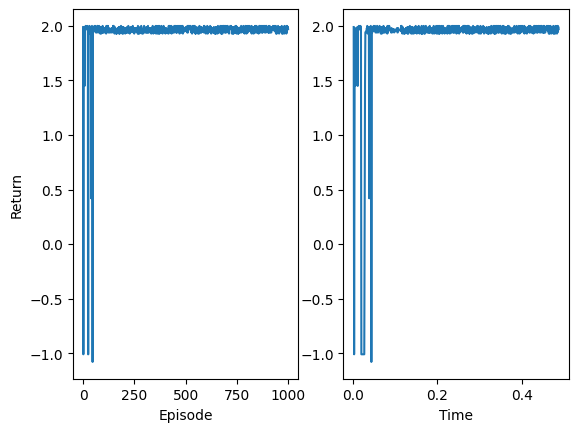

In [ ]:
policy, e_returns, t_returns = policy_iteration(1000)

gw = gw_constructor()
print("GridWorld Layout (Start position randomized)")
print(gw)
print("Final policy")
print(policy_repr(policy, gw.goal), "\n")

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(e_returns)
ax1.set(xlabel = 'Episode', ylabel = 'Return')
ax2.plot(t_returns.keys(), t_returns.values())
ax2.set(xlabel = 'Time')
fig.show()